# Imports

In [1]:
# imports

import os
import numpy as np
import random
import pandas as pd
import json
import pickle
import matplotlib.pyplot as plt
import cv2
from utils import *

from skimage.feature import hog

# Helper Functions

In [2]:
# define a function to display basic stats for images within each class (given a file subset)
def get_image_statistics(files):
    class_stats = []
    
    for class_name in set([file[0] for file in files]):
        class_files = [file[1] for file in files if file[0] == class_name]
        num_files = len(class_files)
        file_types = []
        file_shapes = []
        file_sizes = []
        avg_red_intensity = []
        avg_green_intensity = []
        avg_blue_intensity = []
        min_intensities = []
        max_intensities = []
        
        for file in class_files:
            file_path = os.path.join(directory, class_name, file)
            img = plt.imread(file_path)
            file_types.append(img.dtype)
            file_shapes.append(img.shape)
            file_sizes.append(os.path.getsize(file_path))
            min_intensities.append(np.min(img))
            max_intensities.append(np.max(img))
            avg_red_intensity.append(np.mean(img[:,:,0]))
            avg_green_intensity.append(np.mean(img[:,:,1]))
            avg_blue_intensity.append(np.mean(img[:,:,2]))
            
        most_common_type = max(set(file_types), key=file_types.count)
        most_common_shape = max(set(file_shapes), key=file_shapes.count)
        most_common_type_percentage = (file_types.count(most_common_type) / num_files) * 100
        most_common_shape_percentage = (file_shapes.count(most_common_shape) / num_files) * 100
        avg_size_kb = np.mean(file_sizes) / 1024  # Convert bytes to KB
        
        class_stats.append([class_name, avg_size_kb, num_files, most_common_type, most_common_type_percentage,
                            most_common_shape, most_common_shape_percentage,
                            np.min(min_intensities), np.max(max_intensities),
                            np.mean(avg_red_intensity), np.mean(avg_green_intensity), np.mean(avg_blue_intensity)])
        
    df = pd.DataFrame(class_stats, columns=["Class", "Avg Size (KB)", "Num Files", "Most Common Type", "% Common Type",
                                            "Most Common Shape", "% Common Shape",
                                            "Min Intensity", "Max Intensity",
                                            "Avg Red Intensity", "Avg Green Intensity", "Avg Blue Intensity"])
    return df

In [3]:
# define a function to show a grid of images in a directory (given a file subset)
def generate_image_grid(files, directory, images_per_class=3):
    # create a dictionary to store class images
    class_images = {}
    
    # iterate over each file
    for class_name, file_name in files:
        # load the image
        img = plt.imread(os.path.join(directory, class_name, file_name))
        # if class not in dictionary, initialize empty list
        if class_name not in class_images:
            class_images[class_name] = []
        # append image to class list
        class_images[class_name].append(img)

    # create a grid of images
    num_classes = len(class_images)
    fig, axes = plt.subplots(num_classes, images_per_class + 1, figsize=(9, 1*num_classes))
    for i, (class_name, images) in enumerate(class_images.items()):
        # display class name in the first column
        axes[i, 0].text(0.5, 0.5, class_name, fontsize=12, ha='center', va='center')
        axes[i, 0].axis('off')

        # display random images in the subsequent columns
        random.shuffle(images)
        for j in range(images_per_class):
            axes[i, j+1].imshow(images[j])
            axes[i, j+1].axis('off')

    plt.tight_layout()
    plt.show()

In [4]:
# define a function to generate a grid of histograms of intensity counts for each channel
# in each image in each class
def generate_hist_channel_grid(files, directory, channels='rgb'):
    
    if channels=='rgb':
        ch1 = 'Red'
        ch2 = 'Green'
        ch3 = 'Blue'
        colors = ['r', 'g', 'b']  # Specify colors for RGB channels
    elif channels=='lab':
        ch1 = 'L*'
        ch2 = 'a*'
        ch3 = 'b*'
        colors = ['k', 'y', 'c']  # Specify colors for Lab channels
    
    class_histograms = {}

        # iterate over each file
    for class_name, file_name in files:
        # load the image
        img = plt.imread(os.path.join(directory, class_name, file_name))
        if channels=='lab':
            img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB) # convert image to L*a*b* color space

        # if class not in dictionary, initialize empty lists for histograms
        if class_name not in class_histograms:
            class_histograms[class_name] = {ch1: np.zeros(256), ch2: np.zeros(256), ch3: np.zeros(256)}

        # compute histograms for each color channel
        for channel, color in enumerate(colors):
            hist, _ = np.histogram(img[:,:,channel].flatten(), bins=256, range=(0, 256))
            class_histograms[class_name][[ch1, ch2, ch3][channel]] += hist

    # create a grid of histograms
    num_classes = len(class_histograms)
    fig, axes = plt.subplots(num_classes, 4, figsize=(9, 2*num_classes))
    for i, (class_name, histograms) in enumerate(class_histograms.items()):
        # display class name in the first column
        axes[i, 0].text(0.5, 0.5, class_name, fontsize=12, ha='center', va='center')
        axes[i, 0].axis('off')
        
        # plot histograms for each color channel
        for j, (color, hist) in enumerate(histograms.items()):
            axes[i, j+1].bar(np.arange(256), hist, color=colors[j])  # use colors defined earlier
            
            # set plot properties
            axes[i, j+1].set_xlim(0, 255)
            axes[i, j+1].set_ylim(0, np.max(list(histograms.values())) * 1.1)
            axes[i, j+1].set_xlabel('Intensity')
            axes[i, j+1].set_ylabel('Frequency')
            axes[i, j+1].set_title(color)

    plt.tight_layout()
    plt.show()

In [5]:

def generate_dist_channel_grid(files, directory, bins=50, channels='rgb'):
    
    if channels=='rgb':
        ch1 = 'Red'
        ch2 = 'Green'
        ch3 = 'Blue'
        colors = ['r', 'g', 'b']  # specify colors for RGB channels
    elif channels=='lab':
        ch1 = 'L*'
        ch2 = 'a*'
        ch3 = 'b*'
        colors = ['k', 'y', 'c']  # specify colors for Lab channels

    # create a dictionary to store class histograms
    class_histograms = {}

    # iterate over each file
    for class_name, file_name in files:
        # load the image
        img = plt.imread(os.path.join(directory, class_name, file_name))
        if channels=='lab':
            img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)  # convert image to L*a*b* color space
        
        # calculate histograms for each color channel
        ch1_hist, _ = np.histogram(img[:,:,0], bins=bins, range=(0, 255))
        ch2_hist, _ = np.histogram(img[:,:,1], bins=bins, range=(0, 255))
        ch3_hist, _ = np.histogram(img[:,:,2], bins=bins, range=(0, 255))

        # if class not in dictionary, initialize empty lists for histograms
        if class_name not in class_histograms:
            class_histograms[class_name] = {ch1:[], ch2:[], ch3:[]}

        # append histograms to class list
        class_histograms[class_name][ch1].append(ch1_hist)
        class_histograms[class_name][ch2].append(ch2_hist)
        class_histograms[class_name][ch3].append(ch3_hist)

    # create a grid of histograms
    num_classes = len(class_histograms)
    fig, axes = plt.subplots(num_classes, 4, figsize=(9, 2*num_classes))
    for i, (class_name, histograms) in enumerate(class_histograms.items()):
        # display class name in the first column
        axes[i, 0].text(0.5, 0.5, class_name, fontsize=12, ha='center', va='center')
        axes[i, 0].axis('off')

        # plot average histograms for each color channel
        for j, (color, hist_data) in enumerate(histograms.items()):
            avg_hist = np.mean(hist_data, axis=0)
            axes[i, j+1].plot(avg_hist, color=colors[j], lw=2)  # use colors defined earlier
            if i == 0:
                axes[i, j+1].set_title(color.capitalize())
            if j == 0:
                axes[i, j+1].set_ylabel('Frequency')
            if i == num_classes - 1:
                axes[i, j+1].set_xlabel('Brightness')
            axes[i, j+1].set_xticks([])
            axes[i, j+1].set_yticks([])

    plt.tight_layout()
    plt.show()

In [6]:
# define a function to generate a grid of smoothed distributions of mean intensity counts in each channel
# for each class across all images in each class
def generate_channel_dist_grid(files, directory, bins=20, channels='rgb'):
    
    if channels=='rgb':
        ch1 = 'r' #'Red'
        ch2 =  'g' #'Green'
        ch3 = 'b' #'Blue'
    elif channels=='lab':
        ch1 = 'L*'
        ch2 = 'a*'
        ch3 = 'b*'
    elif channels=='hsv':
        ch1 = 'h' #'Hue'
        ch2 = 's' #'Saturation'
        ch3 = 'v' #'Value'

    # create a dictionary to store class histograms
    class_histograms = {}
    # create a dictionary to store legend color mapping
    legend_color_mapping = {}

    # create a dictionary to store, for each class, a list vectors comprised of the distribution for each of the 3 channels
    feature_vectors = {}

    # iterate over each file
    for class_name, file_name in files:
        # Load the image
        img = plt.imread(os.path.join(directory, class_name, file_name))
        if channels=='lab':
            img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB) # convert image to L*a*b* color space
        elif channels=='hsv':
            img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) # convert image to HSV color space
        
        # calculate histograms for each color channel
        ch1_hist, _ = np.histogram(img[:,:,0], bins=bins, range=(0, 255))
        ch2_hist, _ = np.histogram(img[:,:,1], bins=bins, range=(0, 255))
        ch3_hist, _ = np.histogram(img[:,:,2], bins=bins, range=(0, 255))
       
        # if class not in features, initialize empty list for distributions
        if class_name not in feature_vectors:
            feature_vectors[class_name] = []
        
        # generate a vector that concatenates all 3 channel distributions
        image_vector = np.concatenate((ch1_hist, ch2_hist, ch3_hist))
        feature_vectors[class_name].append(image_vector)
        
        # generate a list of feature names
        feature_names = [f"ch1_{i}" for i in range(1,bins+1)] + [f"ch2_{i}" for i in range(1,bins+1)] + [f"ch3_{i}" for i in range(1,bins+1)]
        
        
        # if class not in dictionary, initialize empty lists for histograms
        if class_name not in class_histograms:
            class_histograms[class_name] = {
                ch1: [],
                ch2: [],
                ch3: []
            }

        # append histograms to class list
        class_histograms[class_name][ch1].append(ch1_hist)
        class_histograms[class_name][ch2].append(ch2_hist)
        class_histograms[class_name][ch3].append(ch3_hist)
        # store legend color mapping
        if class_name not in legend_color_mapping:
            legend_color_mapping[class_name] = plt.cm.tab10(len(legend_color_mapping))

    # create a grid of histograms
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    for color_index, color_channel in enumerate([ch1, ch2, ch3]):
        # plot curves for each class
        for class_name, histograms in class_histograms.items():
            avg_hist = np.mean(histograms[color_channel], axis=0)
            axes[color_index].plot(avg_hist, color=legend_color_mapping[class_name], label=class_name)
        if color_index == 0:
            axes[color_index].set_ylabel('Frequency')
        axes[color_index].set_title(f'{color_channel.capitalize()} Channel')
        axes[color_index].set_xlabel('Mean Intensity')
        axes[color_index].set_xticks([])
        axes[color_index].set_yticks([])

    # show legend for the last plot
    axes[-1].legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Class')
    plt.tight_layout()
    plt.show()

    return feature_vectors, feature_names, class_histograms, legend_color_mapping

In [7]:
# define a function that determines the hog descriptors for an image's grayscale representation
def compute_hog_stats(image_path):
    # read the image
    img = cv2.imread(image_path)
    
    # convert image to grayscale
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # compute HOG features
    fd, hog_image = hog(gray_img, orientations=4, pixels_per_cell=(32, 32), visualize=True)
    
    return fd, hog_image

In [8]:
# define a function to show a grid of random images and hog representation from a directory (given a file subset)
def generate_hog_image_grid(files, directory, images_per_class=2):

    # create a dictionary to store class images and their HOG images
    class_images = {}
    
    # iterate over each file
    for class_name, file_name in files:
        # load the image
        img = plt.imread(os.path.join(directory, class_name, file_name))
        # if class not in dictionary, initialize empty list
        if class_name not in class_images:
            class_images[class_name] = []

        # compute HOG image
        fd, hog_image = compute_hog_stats(os.path.join(directory, class_name, file_name))

        # append image and its HOG representation to class list
        class_images[class_name].append((img, hog_image))

    # create a grid of images
    num_classes = len(class_images)
    fig, axes = plt.subplots(num_classes, 5, figsize=(12, 2*num_classes))
    for i, (class_name, images) in enumerate(class_images.items()):
        # display class name in the first column
        axes[i, 0].text(0.5, 0.5, class_name, fontsize=12, ha='center', va='center')
        axes[i, 0].axis('off')

        # display random images and their HOG representations in the subsequent columns
        random.shuffle(images)
        for j in range(images_per_class):
            axes[i, j*2+1].imshow(images[j][0], cmap='gray')
            axes[i, j*2+1].axis('off')
            axes[i, j*2+2].imshow(images[j][1], cmap='gray')
            axes[i, j*2+2].axis('off')

    plt.tight_layout()
    plt.show()

# Import and split data

In [9]:
# define file directory
directory = '../data/interim/PatternNet/PatternNet/images'

# create a list of all possible classes
all_classes = []
for item in os.listdir(directory):
    item_path = os.path.join(directory, item)
    if os.path.isdir(item_path):
        all_classes.append(item)
#print(all_classes)
        
# create a list of classes considered for this project
classes = ['beach', 'chaparral', 'dense_residential', 'forest', 'freeway', 'harbor', 'overpass', 'parking_space', 'river', 'swimming_pool']
        
# inspect the number of images per class
data = []
for class_name in classes:
    class_dir = os.path.join(directory, class_name)
    image_count = len(os.listdir(class_dir))
    data.append([class_name, image_count])
image_count_df = pd.DataFrame(data, columns=['Class', 'Total Image Count'])
print("The following classes were selected for evaluation:")
display(image_count_df)

# define the train, val, and test sets
train_files, val_files, test_files = generate_splits(classes, directory)

The following classes were selected for evaluation:


Class  Total Image Count
0              beach                799
1          chaparral                800
2  dense_residential                800
3             forest                800
4            freeway                800
5             harbor                800
6           overpass                800
7      parking_space                800
8              river                800
9      swimming_pool                800

train/validation/test subsets were loaded from a pre-generated file
	Number of train files: 4799
	Number of val files: 1599
	Number of test files: 1601


# Investigate basics

In [10]:
# show a table of basic statistics for classes in the train set
train_df = get_image_statistics(train_files)
display(train_df)

Class  Avg Size (KB)  Num Files Most Common Type  \
0             harbor      70.556911        480            uint8   
1            freeway      15.917944        480            uint8   
2              beach      18.535264        479            uint8   
3             forest      71.449888        480            uint8   
4      parking_space      43.724428        480            uint8   
5           overpass      21.470199        480            uint8   
6  dense_residential      83.543789        480            uint8   
7              river      11.682515        480            uint8   
8          chaparral      24.814231        480            uint8   
9      swimming_pool      80.297563        480            uint8   

   % Common Type Most Common Shape  % Common Shape  Min Intensity  \
0          100.0     (256, 256, 3)           100.0              0   
1          100.0     (256, 256, 3)           100.0              0   
2          100.0     (256, 256, 3)           100.0              0   
3          100.0     (256, 256, 3)           100.0              0   
4          100.0     (256, 256, 3)           100.0              0   
5          100.0     (256, 256, 3)           100.0              0   
6          100.0     (256, 256, 3)           100.0              0   
7          100.0     (256, 256, 3)           100.0              0   
8          100.0     (256, 256, 3)           100.0              0   
9          100.0     (256, 256, 3)           100.0              0   

   Max Intensity  Avg Red Intensity  Avg Green Intensity  Avg Blue Intensity  
0            255          63.476768            68.929459           66.475761  
1            255         118.002265           116.858609          106.322258  
2            255         131.951755           135.024227          113.161730  
3            255          35.480526            41.016052           31.038836  
4            255          98.533777           100.149745           94.503926  
5            255          98.721865            99.461992           87.583254  
6            255          85.731866            83.708735           74.711743  
7            255          53.290512            58.634426           47.849309  
8            255         134.355693           111.351735           94.586671  
9            255          94.243265           100.657730           90.398918

# Inspect examples

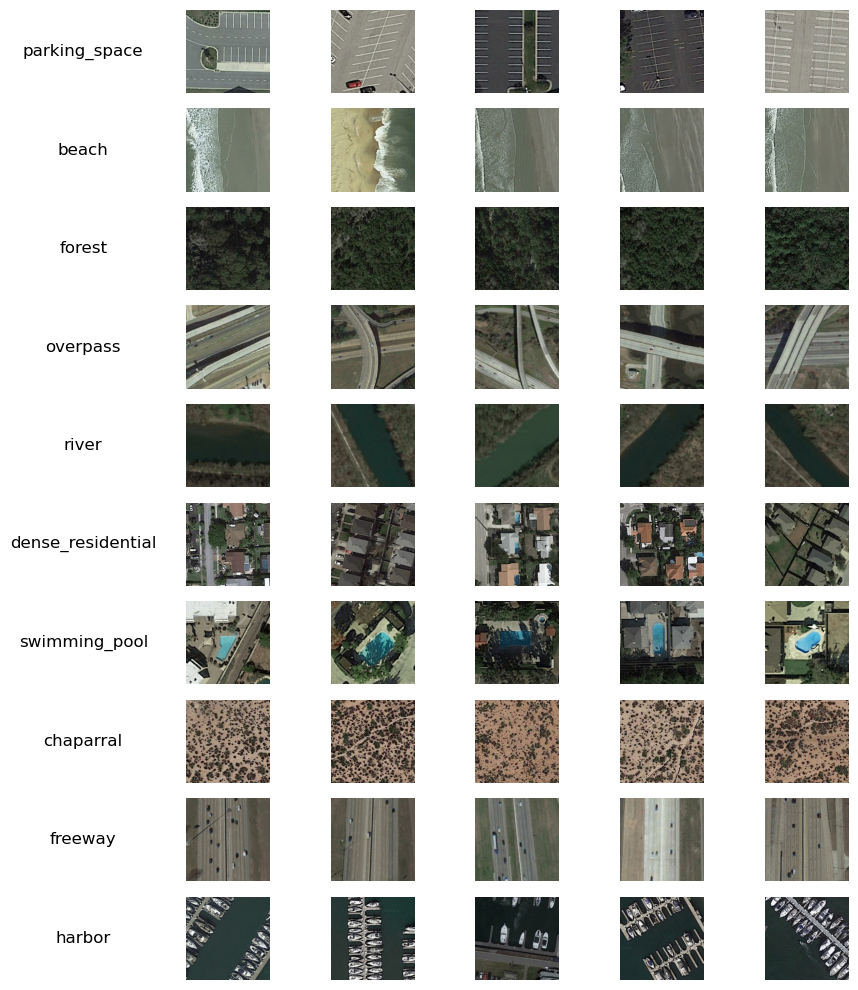

In [11]:
# show a grid with 5 random images per class
generate_image_grid(train_files, directory, 5)

# Visualize RGB Color Distributions

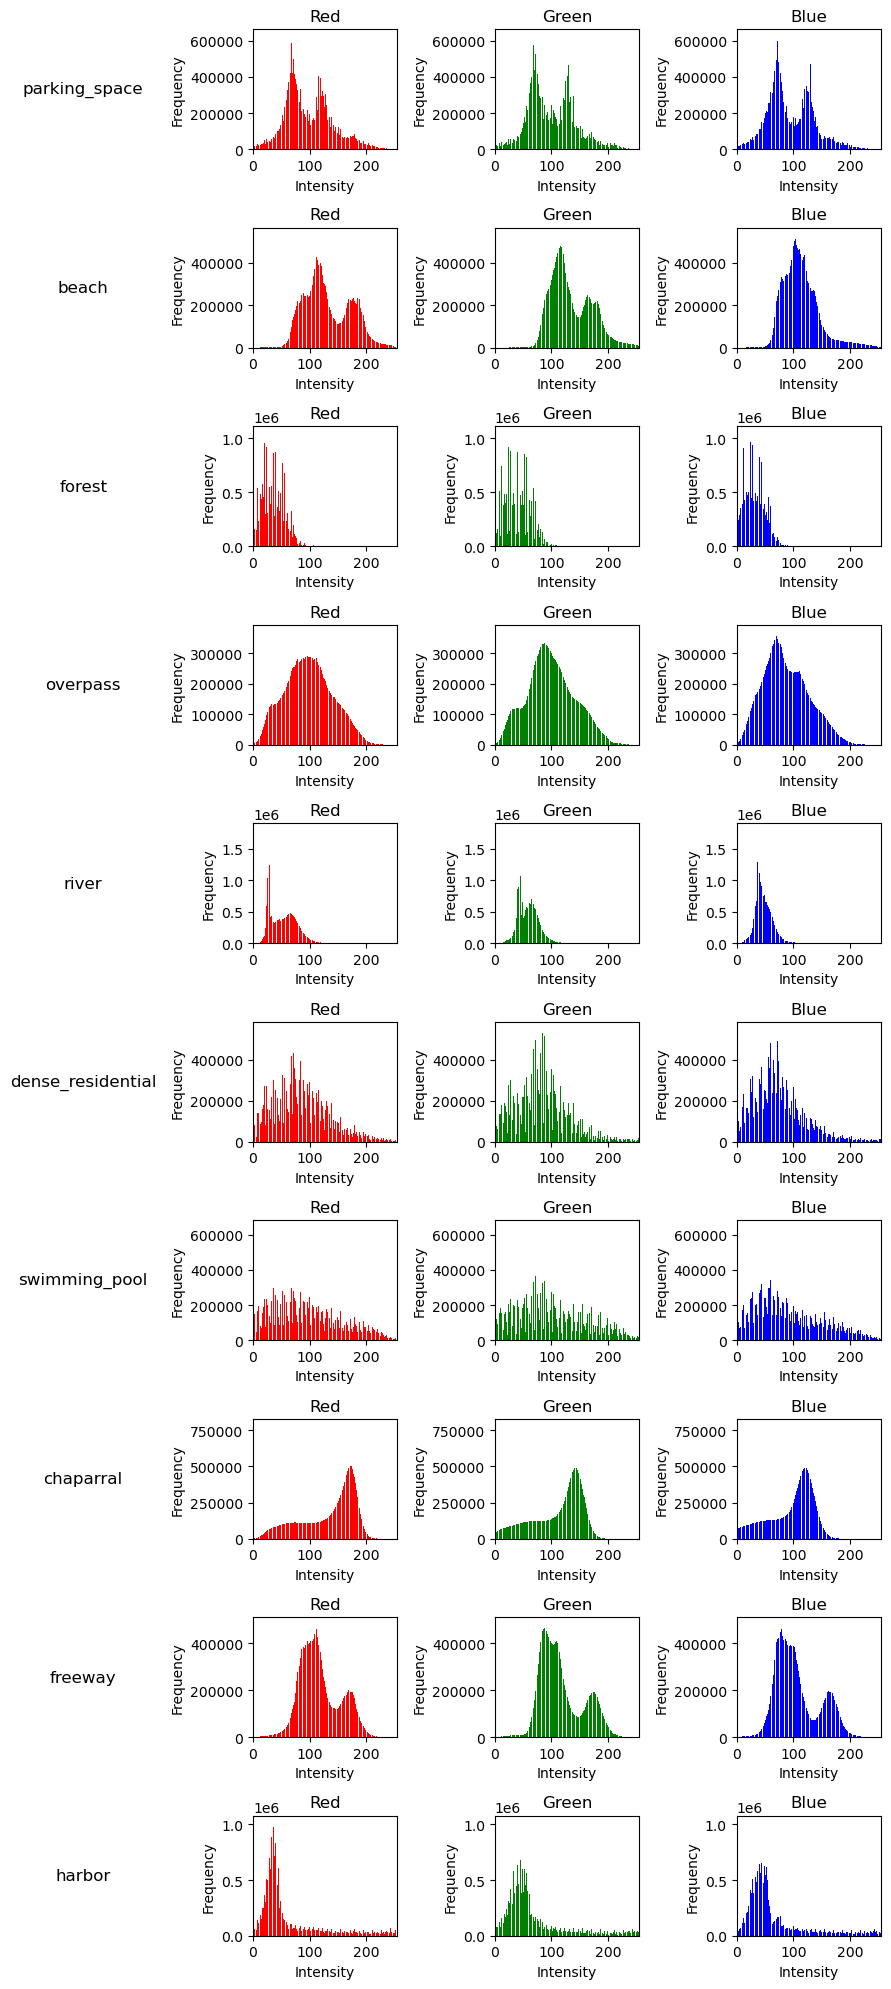

In [12]:
# for each class, show a grid that overlays the histograms of all images for each color channel
generate_hist_channel_grid(train_files, directory, channels='rgb')

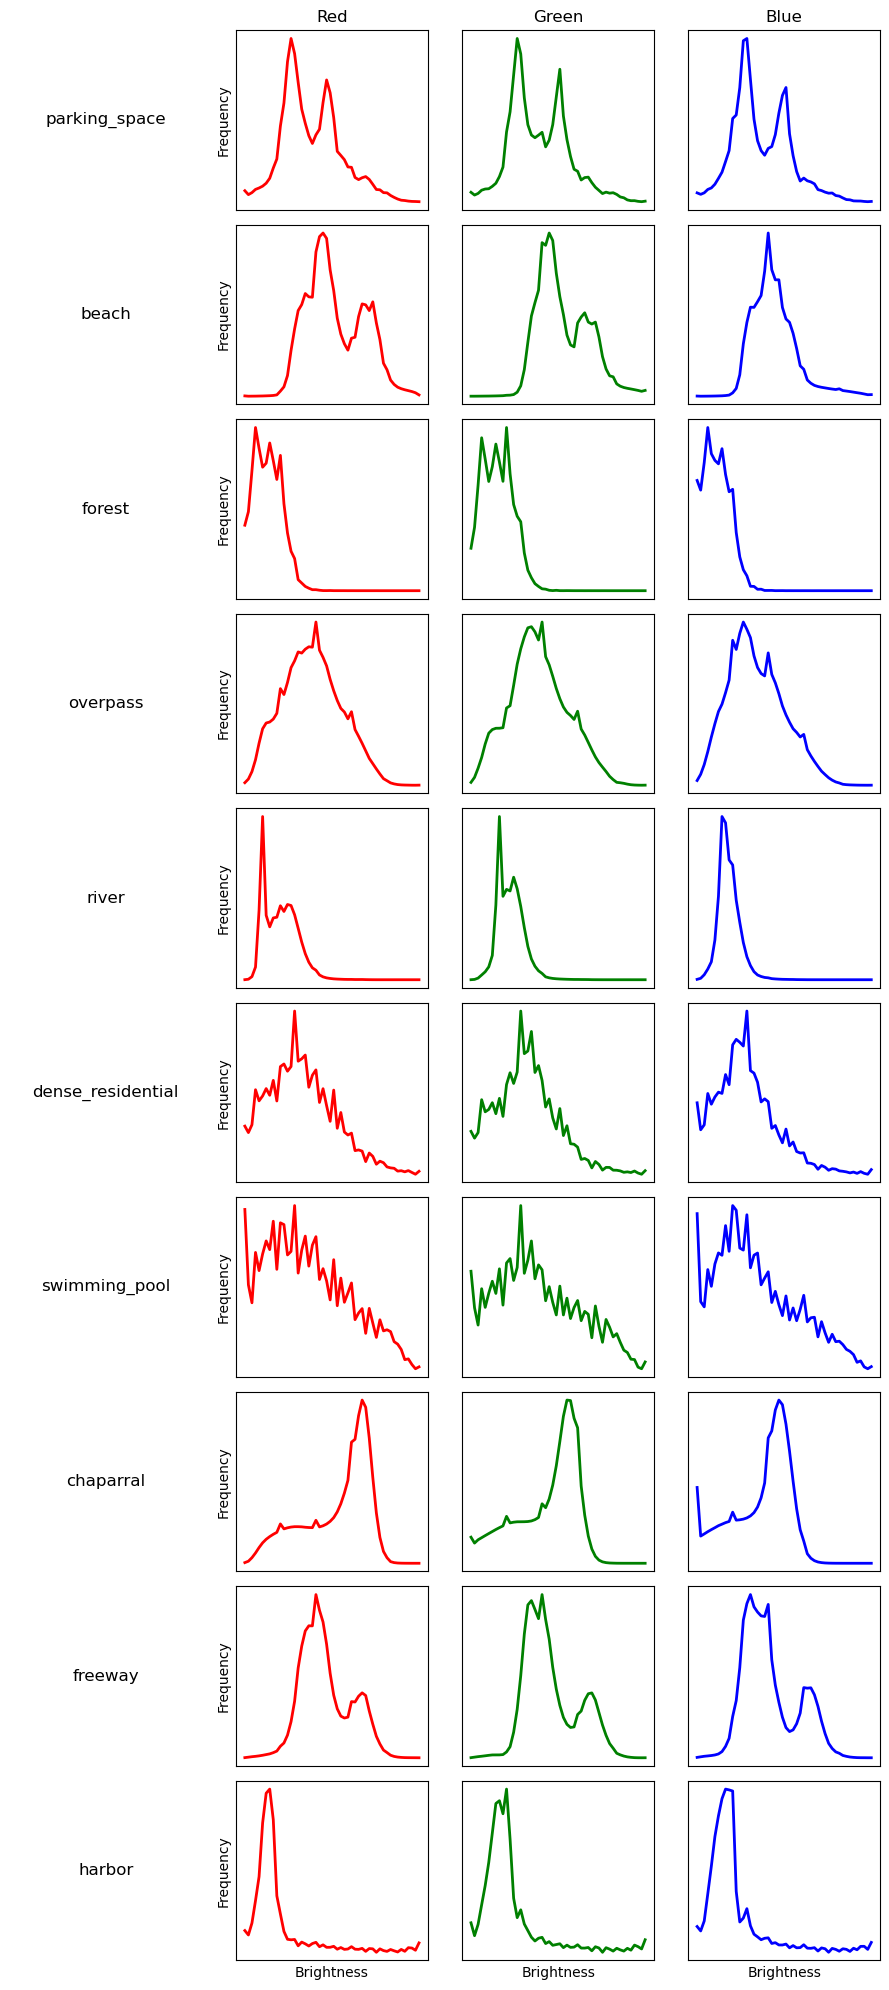

In [13]:
# for each class, show a grid of mean intensity distributions for each color channel
generate_dist_channel_grid(train_files, directory, bins=50, channels='rgb')

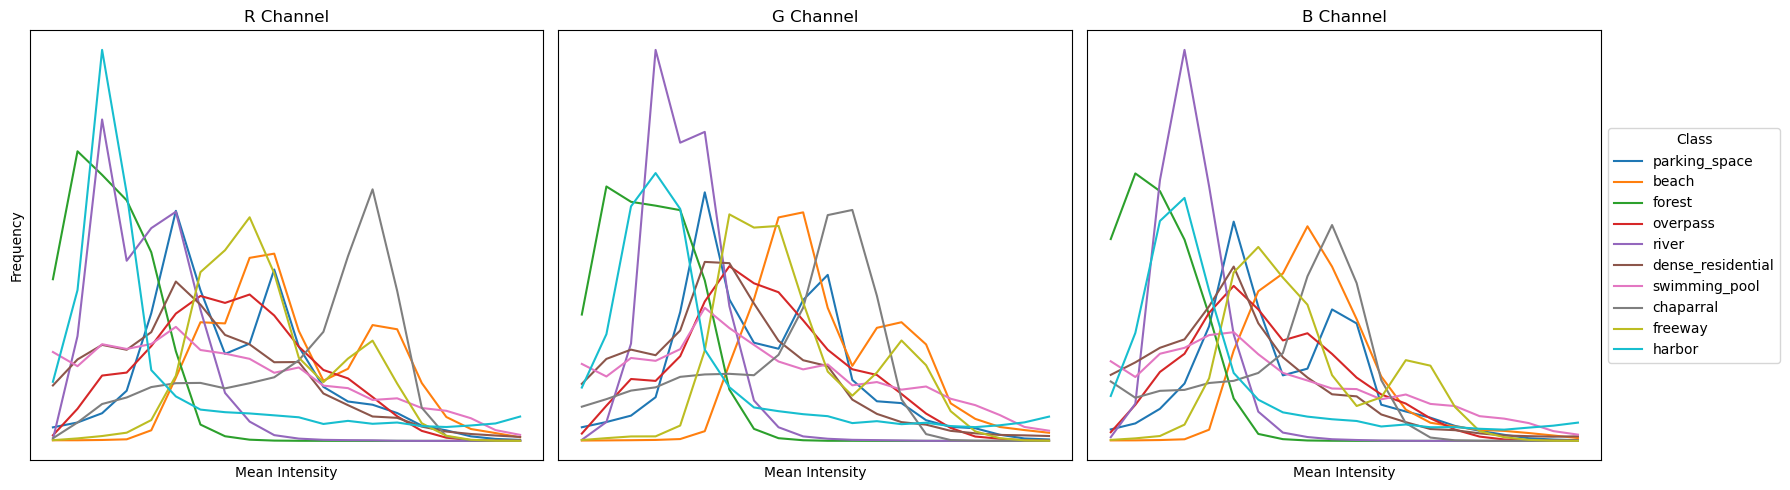

In [14]:
# for each color channel, show a grid of mean intensity distributions for each class
class_histograms_rgb, feature_names_rgb, class_distributions_rgb, legend_color_mapping_rgb = generate_channel_dist_grid(train_files, directory, bins=20, channels='rgb')

# Visualize Lab Color Distributions

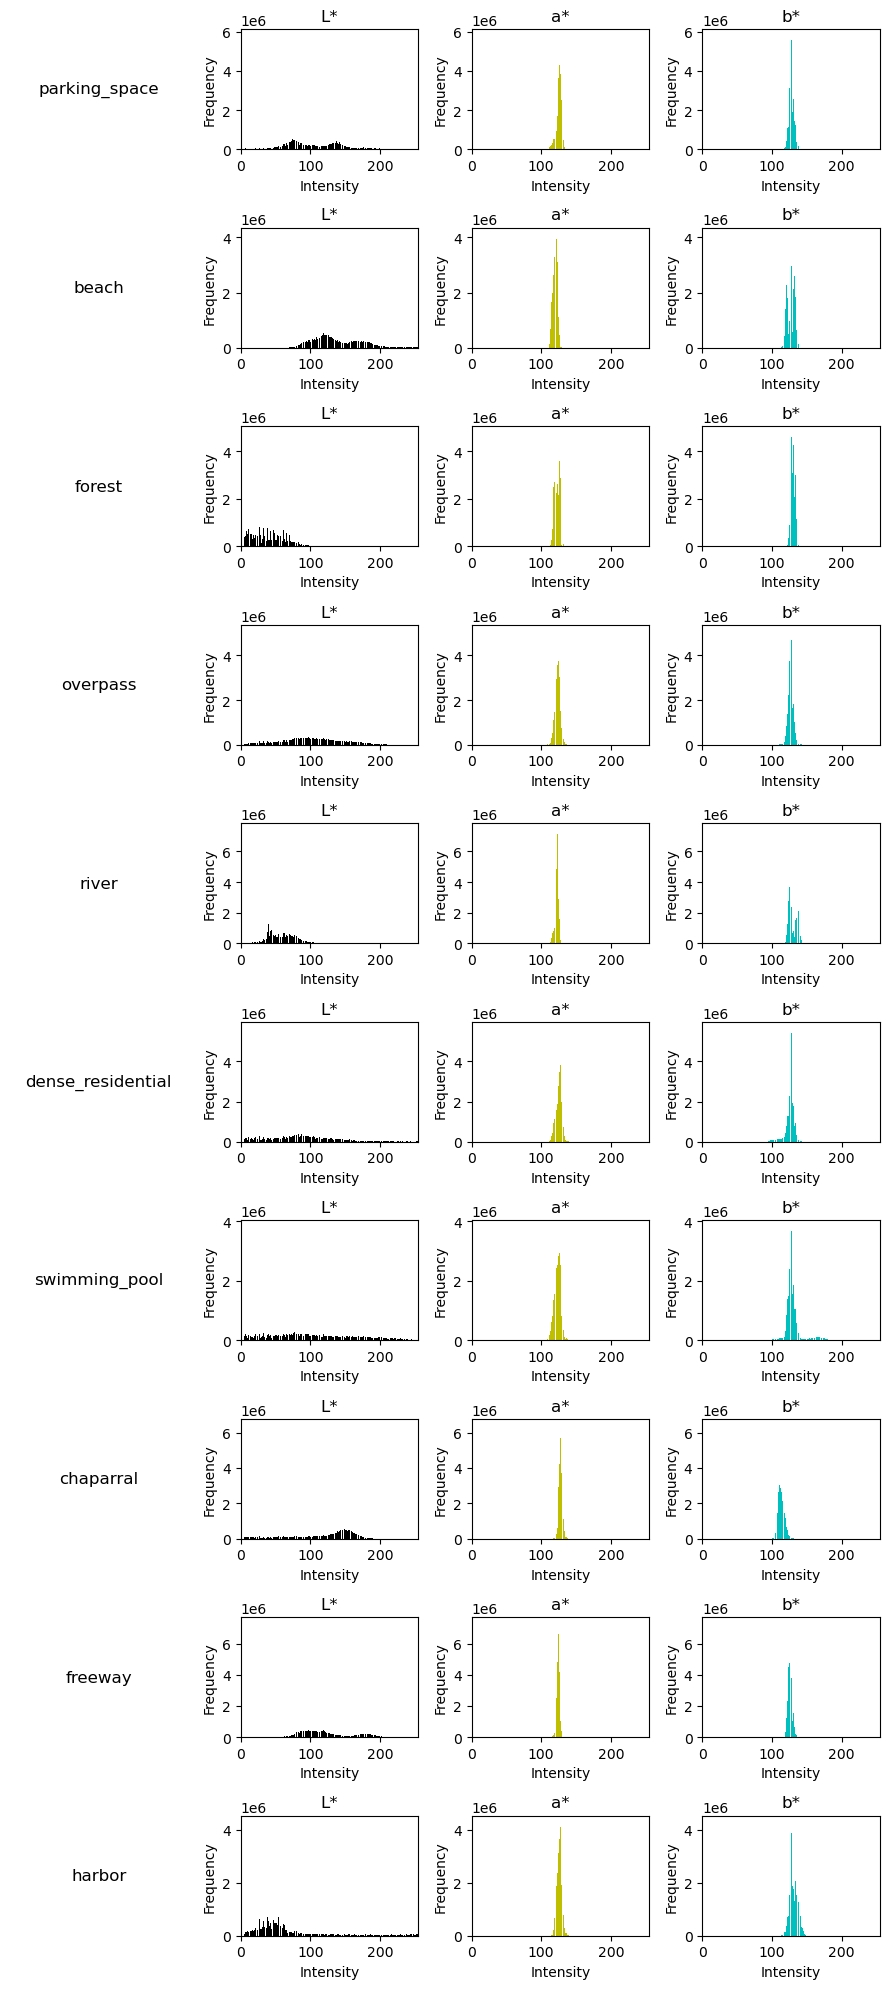

In [15]:
# for each class, show a grid that overlays the histograms of all images for each color channel
generate_hist_channel_grid(train_files, directory, channels='lab')

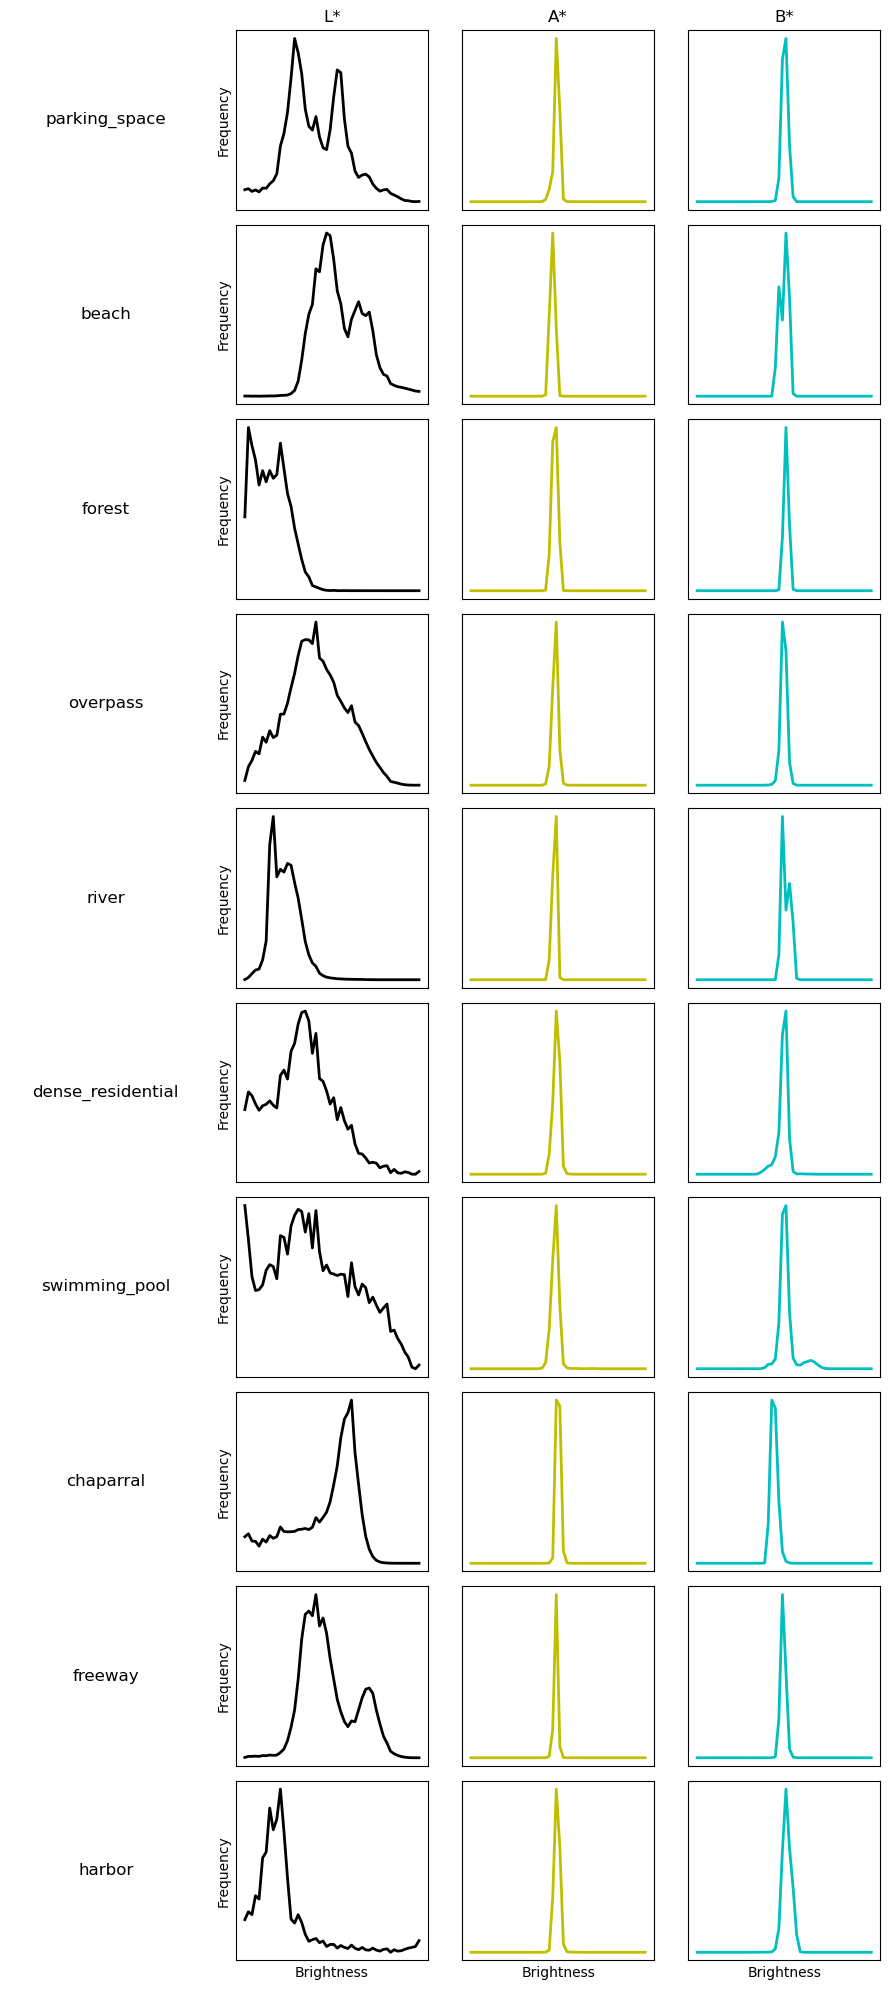

In [16]:
# for each class, show a grid of mean intensity distributions for each color channel
generate_dist_channel_grid(train_files, directory, bins=50, channels='lab')

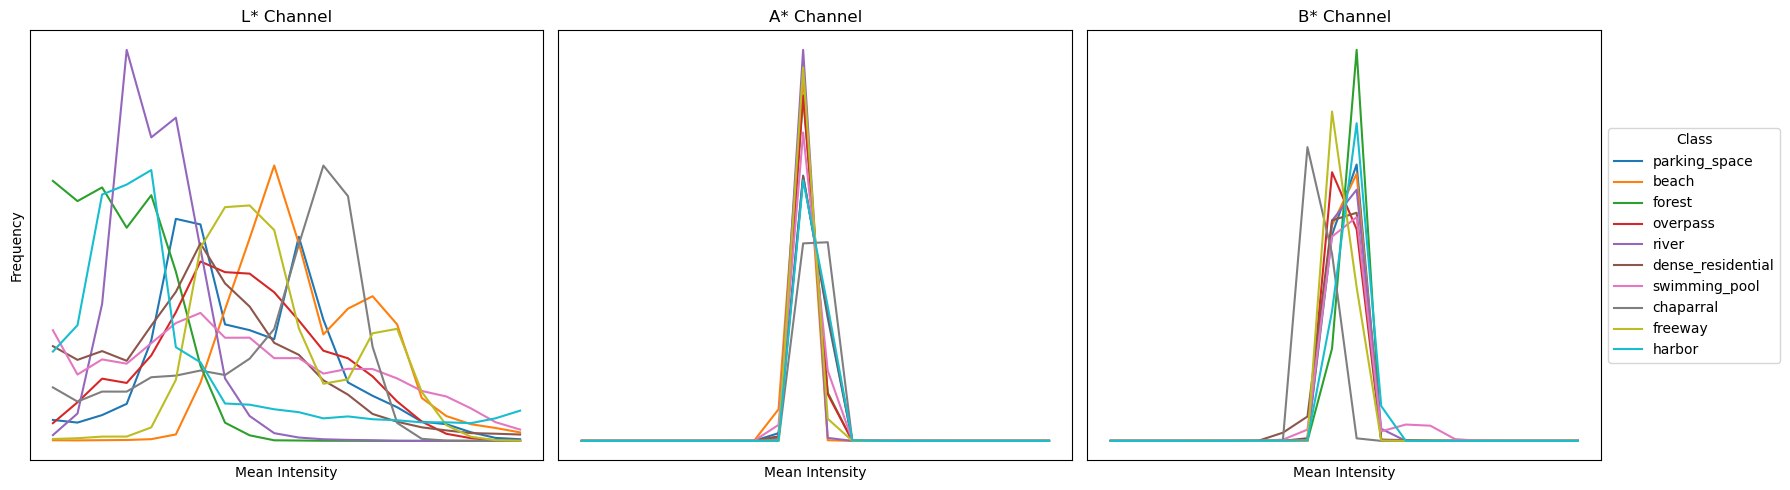

In [17]:
# for each color channel, show a grid of mean intensity distributions for each class
class_histograms_lab, feature_names_lab, class_distributions_lab, legend_color_mapping_lab = generate_channel_dist_grid(train_files, directory, bins=20, channels='lab')

# Visualize HOG

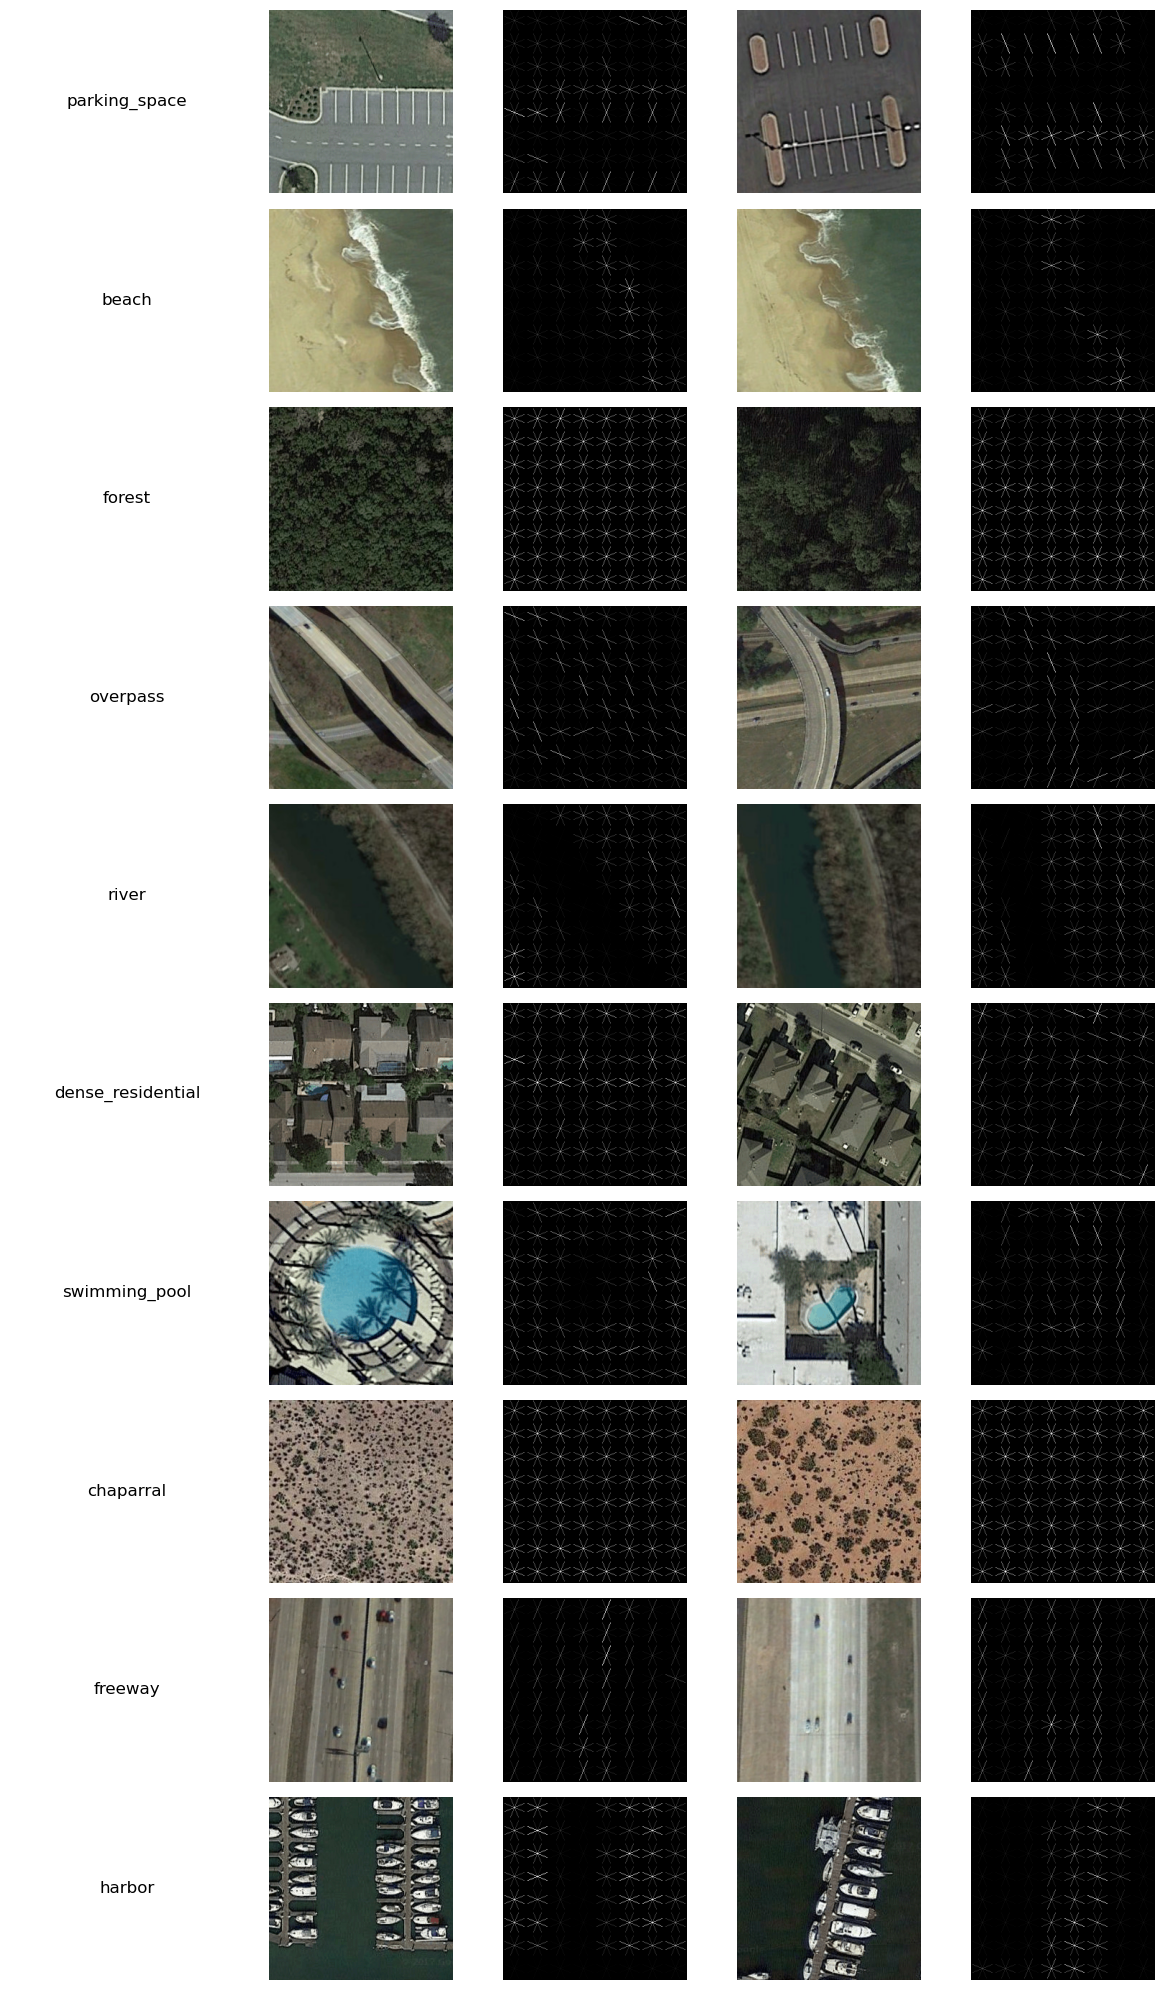

In [18]:
generate_hog_image_grid(train_files, directory)

# Save data

In [19]:
# save histogram data to pickle file
with open('../data/processed/eda_class_rgb_histograms.pkl', 'wb') as f:
    pickle.dump(class_histograms_rgb, f)

# save histogram data to pickle file
with open('../data/processed/eda_class_color_mapping.pkl', 'wb') as f:
    pickle.dump(legend_color_mapping_rgb, f)

In [20]:
# load histogram data from pickle file
with open('../data/processed/eda_class_rgb_histograms.pkl', 'rb') as f:
    class_rgb_histograms = pickle.load(f)

# load class color map from pickle file
with open('../data/processed/eda_class_color_mapping.pkl', 'rb') as f:
    class_color_mapping= pickle.load(f)

In [21]:
print(legend_color_mapping_rgb)

{'parking_space': (0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0), 'beach': (1.0, 0.4980392156862745, 0.054901960784313725, 1.0), 'forest': (0.17254901960784313, 0.6274509803921569, 0.17254901960784313, 1.0), 'overpass': (0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0), 'river': (0.5803921568627451, 0.403921568627451, 0.7411764705882353, 1.0), 'dense_residential': (0.5490196078431373, 0.33725490196078434, 0.29411764705882354, 1.0), 'swimming_pool': (0.8901960784313725, 0.4666666666666667, 0.7607843137254902, 1.0), 'chaparral': (0.4980392156862745, 0.4980392156862745, 0.4980392156862745, 1.0), 'freeway': (0.7372549019607844, 0.7411764705882353, 0.13333333333333333, 1.0), 'harbor': (0.09019607843137255, 0.7450980392156863, 0.8117647058823529, 1.0)}
